In [120]:
import os
import pickle
import secrets
import statistics
from time import time
import tqdm
import numpy as np
import torch

import matplotlib.pyplot as plt

from torchsummary import summary
from sklearn import metrics

from midi2audio import FluidSynth
from IPython.display import Audio, display

import random

In [19]:
data_dirs = {
    
    'data': {
      'out_of_sample': '/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/gothic_horror_movies/processed/10.pickle',

      'transformer_unprompted': '/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/improvised_1000token_hot_start/processed/1600.pickle',

      'transformer_prompted': '/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/gothic_horror_movies/transformer_prompt_processed/1600.pickle',

      'original':'/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/gothic_horror_movies/processed/10.pickle'},
   'embeddings': '/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/token_embeddings.csv'
}


In [194]:
def plot_song(song, title, end_pad = 0, plot_width = 14, plot_height = 5):

    song_f = []

    time = 0
    dur = 0
    vel = 90
    pitch = 0
    channel = 0

    son = []
    song1 = []
    for j in range(0, len(song), 5): # creating penta seqs...
        song1.append(song[j:j+5])

    patch_list = [0] * 16
    patch_list[9] = 128

    channels_list = [0] * 16
    channels_list[9] = 1

    for s in song1: # decoding...

        # 1553 - pad token

        # 1554 - patch change token
        # 1555 - control change token
        # 1556 - key after touch token
        # 1557 - channel after touch token
        # 1558 - pitch wheel change token
        # 1559 - counters seq token

            # 1560 - outro token
            # 1561 - end token
            # 1562 - start token

            if s[0] < 256: # Note

                patch = s[0]
                time += (s[1]-256) * 16
                dur = (s[2]-256-128) * 32
                pitch = (s[3]-256-128-128) % 128
                vel = (s[4]-256-128-128-256)

                if patch in patch_list:
                    channel = patch_list.index(patch)
                    channels_list[channel] = 1

                else:
                    if 0 in channels_list:
                        channel = channels_list.index(0)
                        channels_list[channel] = 1
                        song_f.append(['patch_change', time, channel, patch])

                    else:
                        channel = 15
                        channels_list[channel] = 1
                        song_f.append(['patch_change', time, channel, patch])

                song_f.append(['note', time, dur, channel, pitch, vel])

            if s[0] == 1554: # patch change

                time += (s[1]-256) * 16
                channel = (s[2]-(256+128+128+256+128))
                patch = s[3]

                if channel != 9:
                    patch_list[channel] = patch
                else:
                    patch_list[channel] = patch + 128

                song_f.append(['patch_change', time, channel, patch])

            if s[0] == 1555: # control change

                time += (s[1]-256) * 16
                patch = s[2]
                controller = (s[3]-(256+128+128+256+128+16))
                controller_value = (s[4]-(256+128+128+256+128+16+128))

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['control_change', time, channel, controller, controller_value])

            if s[0] == 1556: # key after touch

                time += (s[1]-256) * 16
                patch = s[2]
                pitch = (s[3]-256-128-128) % 128
                vel = (s[4]-256-128-128-256)

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['key_after_touch', time, channel, pitch, vel])

            if s[0] == 1557: # channel after touch

                time += (s[1]-256) * 16
                patch = s[2]
                vel = (s[3]-256-128-128-256)

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['channel_after_touch', time, channel, vel])

            if s[0] == 1558: # pitch wheel change

                time += (s[1]-256) * 16
                patch = s[2]
                pitch_wheel = (s[3]-(256+128+128+256+128+16+128)) * 128

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['pitch_wheel_change', time, channel, pitch_wheel])


    x = []
    y =[]
    c = []

    colors = ['red']#['red', 'yellow', 'green', 'cyan', 'blue', 'pink', 'orange', 'purple', 'gray', 'white', 'gold', 'silver', 'red', 'yellow', 'green', 'cyan']

    for s in song_f:
        if s[0] == 'note':
            x.append(s[1] / 1000)
            y.append(s[4])
            # c.append(colors[s[3]])
            c.append(colors[0])


    if end_pad > 0:
        pad_vec = [0] * end_pad

        x = [*x, *pad_vec]
        y = [*y, *pad_vec]
        c = [*c, *[colors[0] for x in range(end_pad)]]
    # if render_MIDI_to_audio:
    #     FluidSynth().midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))

    #     # FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))

    #     display(Audio(str(fname + '.wav'), rate=16000))

    plt.figure(figsize=(plot_width,plot_height))
    ax=plt.axes(title=title)
    ax.set_facecolor('black')

    plt.scatter(x,y, c=c)
    plt.xlabel("Time")
    plt.ylabel("Pitch")
    plt.show()

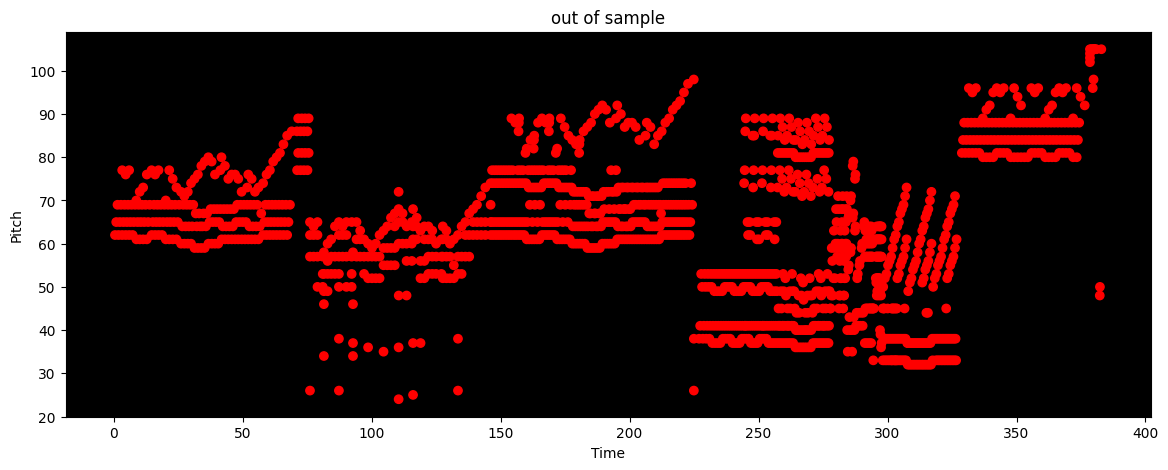

In [25]:
original = pickle.load(open(data_dirs['data']['original'], 'rb'))
plot_song(original[1], 'original')

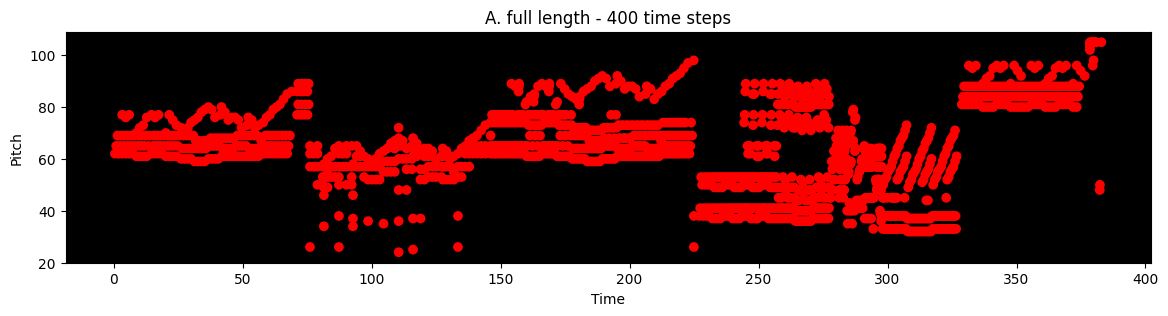

In [201]:
full = pickle.load(open(data_dirs['data']['out_of_sample'], 'rb'))
plot_song(full[1], 'A. full length - 400 time steps', 0, 14, 3)

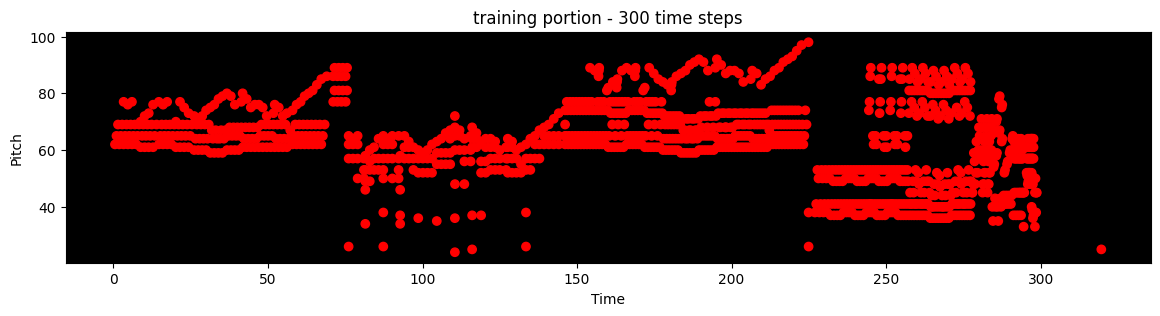

In [198]:
original = pickle.load(open('/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/gothic_horror_movies/song1_train_test.pickle', 'rb'))
plot_song([*original['first_part'][:-5], *[1561 for x in range(5)]], 'B. training portion - 300 time steps', 0, 14, 3)

In [128]:
[*original['first_part'][0:5], *original['last_part']]

[1562,
 1562,
 1562,
 1562,
 1562,
 268,
 417,
 564,
 825,
 0,
 268,
 403,
 550,
 820,
 0,
 270,
 403,
 545,
 825,
 0,
 268,
 503,
 565,
 831,
 0,
 270,
 403,
 550,
 827,
 0,
 268,
 402,
 545,
 827,
 0,
 258,
 433,
 557,
 823,
 0,
 266,
 452,
 567,
 838,
 0,
 270,
 401,
 550,
 828,
 0,
 268,
 403,
 545,
 830,
 0,
 268,
 403,
 568,
 837,
 0,
 268,
 403,
 550,
 829,
 1559,
 1243,
 1308,
 1553,
 1553,
 0,
 270,
 396,
 545,
 834,
 0,
 268,
 511,
 569,
 841,
 0,
 268,
 389,
 557,
 823,
 0,
 256,
 401,
 550,
 830,
 0,
 256,
 389,
 545,
 823,
 0,
 268,
 397,
 557,
 829,
 0,
 256,
 403,
 545,
 832,
 0,
 268,
 410,
 571,
 845,
 0,
 268,
 403,
 550,
 834,
 0,
 258,
 396,
 557,
 824,
 0,
 268,
 396,
 545,
 839,
 0,
 268,
 401,
 573,
 842,
 0,
 256,
 390,
 557,
 817,
 0,
 268,
 403,
 557,
 826,
 0,
 256,
 403,
 550,
 835,
 0,
 256,
 390,
 545,
 825,
 0,
 270,
 396,
 545,
 837,
 0,
 268,
 477,
 574,
 844,
 0,
 268,
 391,
 557,
 827,
 0,
 256,
 403,
 550,
 829,
 0,
 256,
 390,
 545,
 827,
 0,
 268,


In [112]:
def average_tokens(token_list, max = 1000):

    all_vecs = np.zeros(shape = (max, len(token_list)))

    for t in range(len(token_list)):
        all_vecs[:, t] = np.array(token_list[t])[:max]
    
    
    return np.mean(all_vecs, axis = 1).astype(int)
    
    

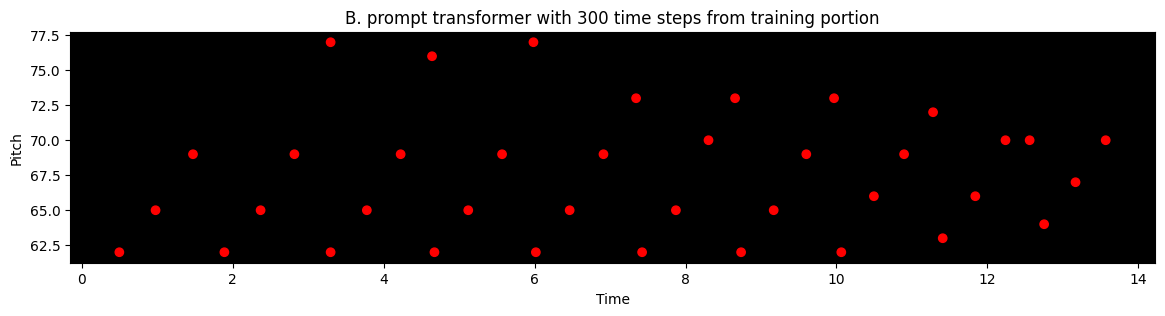

In [202]:
transformer_prompted = pickle.load(open(data_dirs['data']['transformer_prompted'], 'rb'))
plot_song(average_tokens(transformer_prompted, 200), 'B. prompt transformer with 300 time steps from training portion', 0, 14, 3)

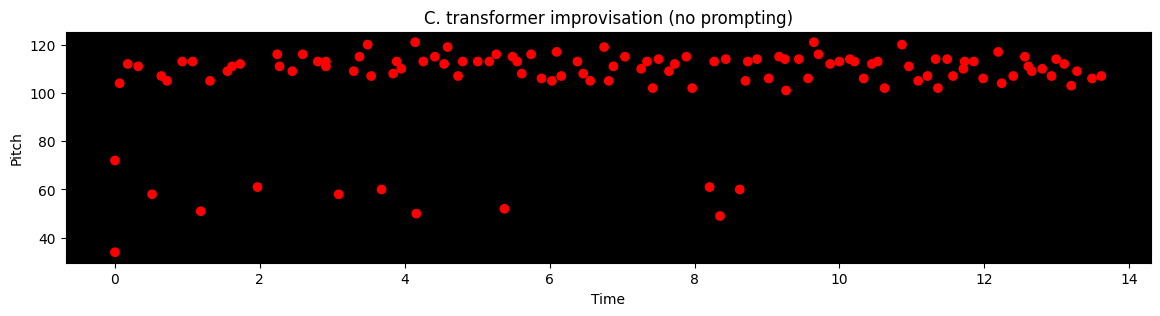

In [203]:
transformer_unprompted = pickle.load(open(data_dirs['data']['transformer_unprompted'], 'rb'))
plot_song(average_tokens(transformer_unprompted, 825), 'C. transformer improvisation (no prompting)', 0, 14, 3)